In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**1. Import các thư viện cần thiết**

In [2]:
# 1. Các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

**2. Đọc file dữ liệu GAS và chia dataset theo tỉ lệ 8:1:1**

In [3]:
# Đọc file dữ liệu
df = pd.read_csv('/content/drive/MyDrive/StockData/GAS.csv')
df = df[['Price']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

# Split the data into training, testing, and validation
train_size = int(0.8 * len(df))
test_size = int(0.1 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

**Xem** **lại** **dataset**

In [4]:
df

,Price
0,98700
1,102900
2,99600
3,97500
4,97200
...,...
1246,92900
1247,92800
1248,92000
1249,92000


**3. Dùng model ARIMA để train data**

In [5]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 31.3 MB/s eta 0:00:00


In [6]:
# Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])
# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True, seasonal = False)
# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=18096.772, Time=3.02 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=18112.424, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=18111.517, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=18111.236, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=18110.491, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=18110.222, Time=0.69 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=18110.397, Time=1.12 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=18098.584, Time=6.68 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=18114.580, Time=1.94 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=18110.690, Time=1.11 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=18111.050, Time=2.18 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=18112.425, Time=0.55 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=18100.045, Time=7.76 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=18094.807, Time=3.62 sec
 ARIMA(1,1,2)(0,0,0

ARIMA(order=(2, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

**4. Quá trình test**

In [12]:
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(n_periods=len(y_test))

**5. Quá trình validate**

In [13]:
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Price'])
y_pred_val =  model.predict(n_periods=len(y_val))

**6. Quá trình tạo index predict 30 ngày tiếp theo**

In [14]:
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[116107.83999727 116276.88427527 115681.09015968 116439.43839513
 115825.14722748 116068.50540227 116261.4967199  115740.97042091
 116361.74328692 115889.1534592  116041.93041945 116243.25722662
 115793.46172932 116298.0158206  115938.54007486 116024.90953729
 116223.8375774  115838.95448709 116246.11546183 115976.23164617
 116014.92884166 116204.39862376 115877.98540079 116204.14828726
 116004.63943109 116010.03468354 116185.71482322 115911.16748236
 116170.4595646  116025.73730252]


***7.Đánh giá độ chính xác thuật toán***

In [15]:
#RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

#MAPE
valid_mape = np.mean(np.abs((y_val - y_pred_val) / y_val)) * 100
test_mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

#MAE
valid_mae = np.mean(np.abs(y_pred_val - y_val))
test_mae = np.mean(np.abs(y_pred - y_test))
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

Validation RMSE: 15196.57866914183
Testing RMSE: 8384.784894721108
Validation MAPE: 14.214596642650863
Testing MAPE: 6.3121367148293
Validation MAE: 14125.273472434335
Testing MAE: 6750.342185618191


**8. Vẽ biểu đồ**

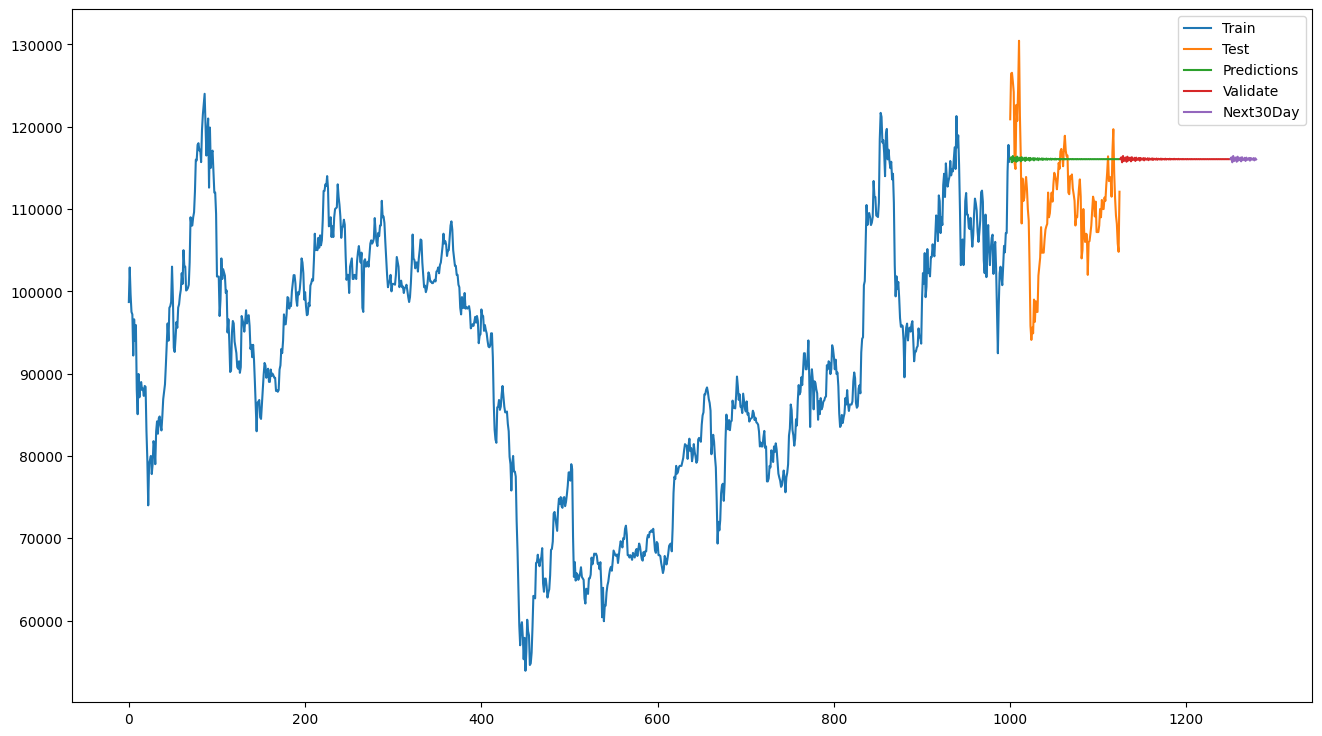

In [16]:
plt.figure(figsize=(16,9))
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()